In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, kl_divergence
from torch.nn.utils import clip_grad_value_
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE

In [2]:
# Encoder: maps the input and label to a latent distribution.
class Encoder(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim, latent_dim):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim) #mean of latent dist
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim) #log var of latent dist

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        h = F.relu(self.enc_fc1(combined))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

# Classifier: Predict class scores from input data.
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = F.relu(self.layer1(x))
        logits = self.layer2(h)
        return logits

# Decoder: Maps the latent vector back to the input space.
class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super().__init__()
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, y):
        combined = torch.cat([z, y], dim=-1)
        h = F.relu(self.dec_fc1(combined))
        x_hat = self.dec_fc2(h)
        return x_hat

In [3]:
# SSL model
class SSL(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, learning_rate):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.classifier = Classifier(input_dim, hidden_dim, num_classes)
        self.encoder = Encoder(input_dim, num_classes, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, hidden_dim, input_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def classify(self, x):
        return self.classifier(x)

    def encode(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z, y):
        return self.decoder(z, y)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_l, y_l, x_u):
        """
        x_l: labeled data
        y_l: labels
        x_u: unlabeled data

        """
        # Obtain classifier scores for labeled and unlabeled data.
        scores_l = self.classifier(x_l)
        scores_u = self.classifier(x_u)
        y_u_prob = F.softmax(scores_u, dim=1)

        # Labeled part
        y_l_onehot = F.one_hot(y_l, self.num_classes).float()
        z_l, mu_l, logvar_l = self.encode(x_l, y_l_onehot)
        x_recon = self.decode(z_l, y_l_onehot)

        # Unlabeled part
        loss_u_components = []
        for i in range(self.num_classes):
            y_u = torch.full((x_u.size(0),), i, dtype=torch.long, device=x_u.device)
            y_u_onehot = F.one_hot(y_u, self.num_classes).float()
            z_u, mu_u, logvar_u = self.encode(x_u, y_u_onehot)
            x_recon_u = self.decode(z_u, y_u_onehot)

            # Compute ELBO loss for this label.
            loss_u = self.elbo_loss(x_u, x_recon_u, mu_u, logvar_u)
            loss_u_components.append(loss_u.unsqueeze(1))

        loss_u_stack = torch.cat(loss_u_components, dim=1)

        # Weight the losses by the classifier’s predicted probabilities.
        loss_u = torch.sum(y_u_prob * (loss_u_stack + torch.log(y_u_prob + 1e-8)), dim=1)

        # Total Loss
        classification_loss = F.cross_entropy(scores_l, y_l)
        labeled_loss = self.elbo_loss(x_l, x_recon, mu_l, logvar_l)
        unlabeled_loss = loss_u.mean()

        total_loss = labeled_loss.mean() + unlabeled_loss + 0.1 * classification_loss

        return total_loss, scores_u

    def elbo_loss(self, x, x_recon, mu, logvar):
        # KL divergence between latent distribution and standard normal
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=1)
        return recon_loss + kld

    def train_step(self, x_l, y_l, x_u):
        # Training loop
        self.optimizer.zero_grad()
        loss, _ = self.forward(x_l, y_l, x_u)
        loss.backward()
        clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def predict(self, x):
        # Prediction
        with torch.no_grad():
            scores = self.classifier(x)
        return torch.argmax(scores, dim=1)

    def visualize_latent_tsne(self, dataloader, num_samples=1000):
        self.eval()
        latents = []
        labels = []

        with torch.no_grad():
            for x, y in dataloader:
                x = x.to(self.device)
                y_onehot = F.one_hot(y, self.num_classes).float().to(self.device)

                # Get latent representation
                z, _, _ = self.encode(x, y_onehot)

                latents.append(z.cpu())
                labels.append(y.cpu())

                if sum(len(l) for l in latents) >= num_samples:
                    break

        latents = torch.cat(latents)[:num_samples].numpy()
        labels = torch.cat(labels)[:num_samples].numpy()

        # Perform T-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latents)

        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels,
                            cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('T-SNE Visualization of Latent Space')
        plt.show()

    def generate_conditional_samples(self, num_samples=10):
        self.eval()
        samples = []

        with torch.no_grad():
            for c in range(self.num_classes):
                # Create class label
                y = torch.full((num_samples,), c, device=self.device)
                y_onehot = F.one_hot(y, self.num_classes).float()

                # Sample from prior
                z = torch.randn(num_samples, self.latent_dim, device=self.device)

                # Generate images
                x_gen = torch.sigmoid(self.decoder(z, y_onehot))
                samples.append(x_gen.cpu())

        # Plot grid
        fig, axs = plt.subplots(self.num_classes, num_samples,
                            figsize=(num_samples, self.num_classes))

        for row in range(self.num_classes):
            for col in range(num_samples):
                axs[row, col].imshow(samples[row][col].view(28, 28).numpy(), cmap='gray')
                axs[row, col].axis('off')

        plt.tight_layout()
        plt.show()


In [4]:
# def prev_power_of_2(n):
#     """Returns the closest power of 2 (rounding down)"""
#     if n < 1:
#         return 1  # Ensure minimum value is at least 1 (or 2 if needed)
#     return 2 ** (n.bit_length() - 1)

## Using same number of labeled and unlabeled datasets for training

In [5]:
# #Training
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# # Hyperparameters.
# input_dim = 28 * 28  # MNIST images
# hidden_dim = 256
# latent_dim = 20
# num_classes = 10
# learning_rate = 1e-3
# batch_size = 64
# num_epochs = 50

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.view(-1))
# ])

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# labels_list = [100, 500, 1000, 3000, 5000] # Different label size

#     # Create a semi-supervised split:

# for labeled_size in labels_list:
#     # Split the dataset into labeled and unlabeled subsets randomly

#     indices = torch.randperm(len(train_dataset))

#     labeled_indices = indices[:labeled_size]
#     unlabeled_indices = indices[labeled_size:]

#     labeled_dataset = Subset(train_dataset, labeled_indices)
#     unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

#     labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
#     unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

#     model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
#     model = model.to(device)
#     epoch_losses = []

#     # Training loop
#     print(f"Starting training with {labeled_size} labels...")
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0

#         for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
#             x_l = x_l.to(model.device)
#             y_l = y_l.to(model.device)
#             x_u = x_u.to(model.device)

#             loss = model.train_step(x_l, y_l, x_u)
#             total_loss += loss

#         avg_loss = total_loss / len(labeled_loader)
#         epoch_losses.append(avg_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

#     # Plot training loss curve
#     plt.figure()
#     plt.plot(epoch_losses, marker='o')
#     plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.grid(True)
#     plt.show()

#     # Evaluate on test data.
#     test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     model.eval()
#     y_true = []
#     y_pred = []
#     with torch.no_grad():
#         for x, y in test_loader:
#             x = x.to(device)  # Move test data to device
#             preds = model.predict(x)
#             y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU
#             y_true.extend(y.numpy())

#     # Calculate accuracy
#     accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
#     print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

#     # Generate confusion matrix
#     cm = confusion_matrix(y_true, y_pred)

#     # Confusion matrix plot
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

#     fig, ax = plt.subplots(figsize=(8, 6))
#     disp.plot(cmap='Blues', ax=ax, values_format='d')

#     ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')
#     plt.show()

#     print('----------------------------------------------------------------')



## Using all unlabeled dataset

Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Starting training with 100 labels and 59900 without labels...
Epoch [1/50], Average Loss: 157.7253
Epoch [2/50], Average Loss: 120.8903
Epoch [3/50], Average Loss: 109.7010
Epoch [4/50], Average Loss: 101.7610
Epoch [5/50], Average Loss: 97.0779
Epoch [6/50], Average Loss: 94.0161
Epoch [7/50], Average Loss: 90.9550
Epoch [8/50], Average Loss: 88.9945
Epoch [9/50], Average Loss: 86.7483
Epoch [10/50], Average Loss: 84.8394
Epoch [11/50], Average Loss: 83.4645
Epoch [12/50], Average Loss: 81.6350
Epoch [13/50], Average Loss: 80.5410
Epoch [14/50], Average Loss: 79.7474
Epoch [15/50], Average Loss: 78.9715
Epoch [16/50], Average Loss: 77.5454
Epoch [17/50], Average Loss: 76.6930
Epoch [18/50], Average Loss: 76.0936
Epoch [19/50], Average Loss: 75.2183
Epoch [20/50], Average Loss: 74.3988
Epoch [21/50], Average Loss: 74.3284
Epoch [22/50], Average Loss: 73.1640
Epoch [23/50], Average Loss: 72.4502
Epoch [24/50], Av

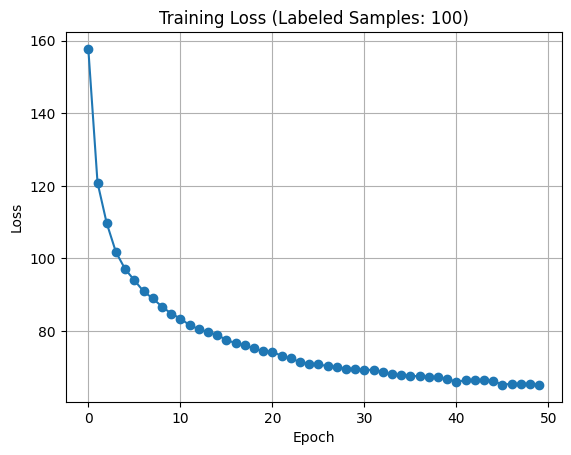

Test Accuracy (100 labels): 60.34%


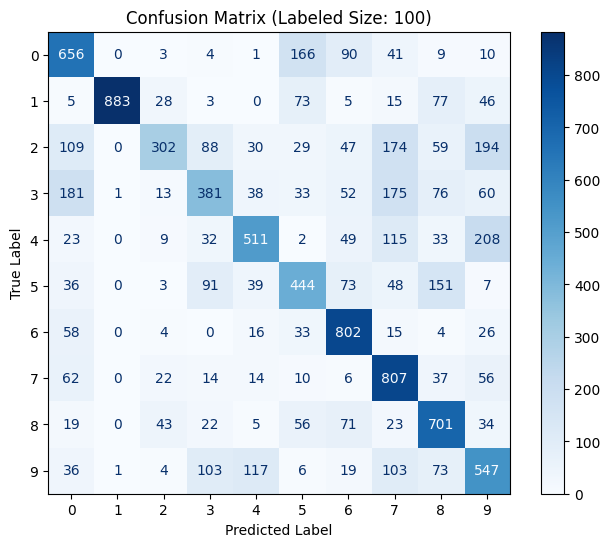

----------------------------------------------------------------
Starting training with 500 labels and 59500 without labels...
Epoch [1/50], Average Loss: 144.0082
Epoch [2/50], Average Loss: 110.1156
Epoch [3/50], Average Loss: 100.0095
Epoch [4/50], Average Loss: 94.8672
Epoch [5/50], Average Loss: 91.7187
Epoch [6/50], Average Loss: 90.6674
Epoch [7/50], Average Loss: 88.6823
Epoch [8/50], Average Loss: 85.1243
Epoch [9/50], Average Loss: 83.1896
Epoch [10/50], Average Loss: 83.0584
Epoch [11/50], Average Loss: 81.9813
Epoch [12/50], Average Loss: 81.7800
Epoch [13/50], Average Loss: 80.4626
Epoch [14/50], Average Loss: 79.9549
Epoch [15/50], Average Loss: 79.2622
Epoch [16/50], Average Loss: 77.9549
Epoch [17/50], Average Loss: 77.9239
Epoch [18/50], Average Loss: 77.2063
Epoch [19/50], Average Loss: 76.4622
Epoch [20/50], Average Loss: 75.6641
Epoch [21/50], Average Loss: 76.2560
Epoch [22/50], Average Loss: 75.1731
Epoch [23/50], Average Loss: 75.3760
Epoch [24/50], Average Loss:

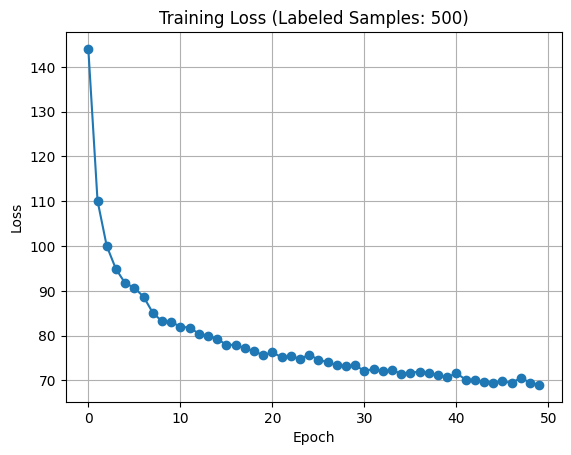

Test Accuracy (500 labels): 85.50%


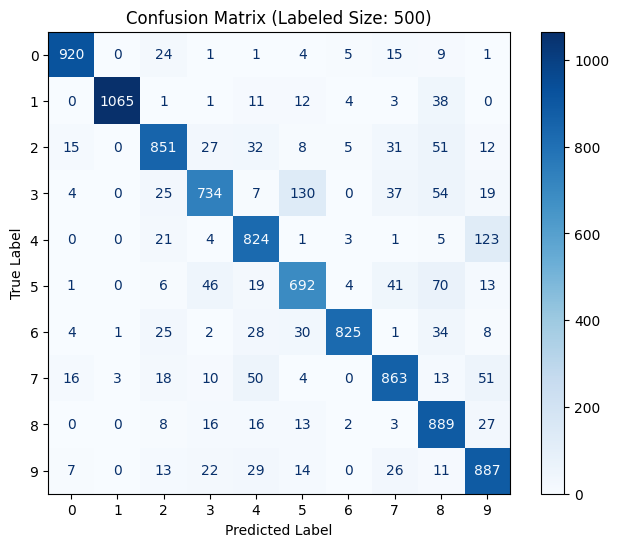

----------------------------------------------------------------
Starting training with 1000 labels and 59000 without labels...
Epoch [1/50], Average Loss: 85.6462
Epoch [2/50], Average Loss: 65.2348
Epoch [3/50], Average Loss: 60.0641
Epoch [4/50], Average Loss: 57.3663
Epoch [5/50], Average Loss: 54.6828
Epoch [6/50], Average Loss: 54.5665
Epoch [7/50], Average Loss: 51.6183
Epoch [8/50], Average Loss: 51.6196
Epoch [9/50], Average Loss: 50.5570
Epoch [10/50], Average Loss: 49.4217
Epoch [11/50], Average Loss: 49.1849
Epoch [12/50], Average Loss: 48.2100
Epoch [13/50], Average Loss: 48.1860
Epoch [14/50], Average Loss: 47.8230
Epoch [15/50], Average Loss: 48.0338
Epoch [16/50], Average Loss: 47.5484
Epoch [17/50], Average Loss: 46.0492
Epoch [18/50], Average Loss: 46.9156
Epoch [19/50], Average Loss: 46.3682
Epoch [20/50], Average Loss: 45.6831
Epoch [21/50], Average Loss: 45.9466
Epoch [22/50], Average Loss: 45.6104
Epoch [23/50], Average Loss: 45.0999
Epoch [24/50], Average Loss: 4

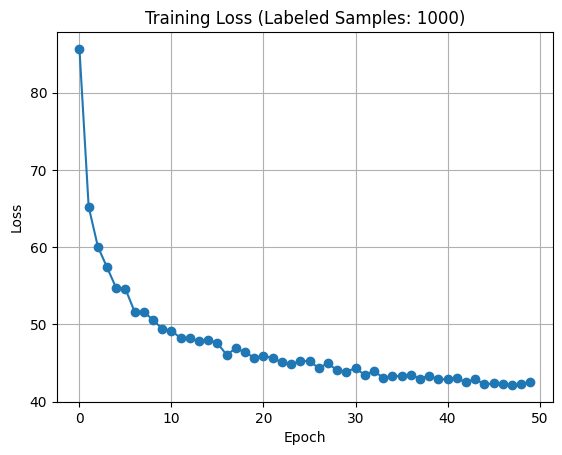

Test Accuracy (1000 labels): 87.66%


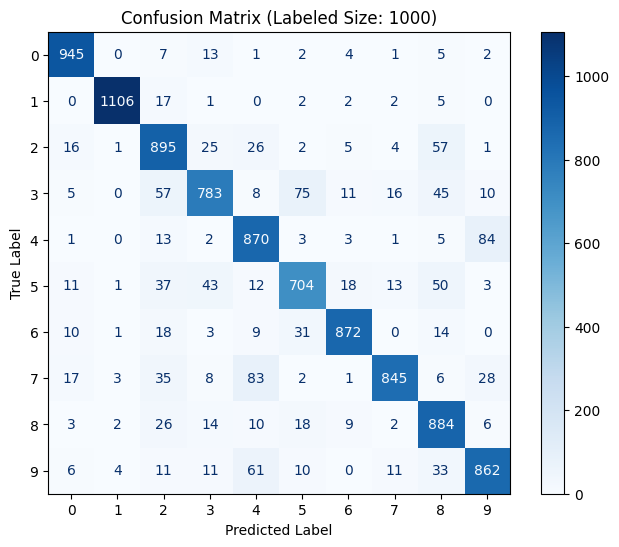

----------------------------------------------------------------
Starting training with 3000 labels and 57000 without labels...
Epoch [1/50], Average Loss: 32.0026
Epoch [2/50], Average Loss: 24.6698
Epoch [3/50], Average Loss: 22.2965
Epoch [4/50], Average Loss: 21.1097
Epoch [5/50], Average Loss: 20.2301
Epoch [6/50], Average Loss: 19.6590
Epoch [7/50], Average Loss: 19.2801
Epoch [8/50], Average Loss: 18.9710
Epoch [9/50], Average Loss: 18.6054
Epoch [10/50], Average Loss: 18.5072
Epoch [11/50], Average Loss: 18.1887
Epoch [12/50], Average Loss: 18.0749
Epoch [13/50], Average Loss: 17.8092
Epoch [14/50], Average Loss: 17.6621
Epoch [15/50], Average Loss: 17.5858
Epoch [16/50], Average Loss: 17.4487
Epoch [17/50], Average Loss: 17.2276
Epoch [18/50], Average Loss: 17.3585
Epoch [19/50], Average Loss: 17.2443
Epoch [20/50], Average Loss: 17.1284
Epoch [21/50], Average Loss: 17.0044
Epoch [22/50], Average Loss: 16.9001
Epoch [23/50], Average Loss: 16.8752
Epoch [24/50], Average Loss: 1

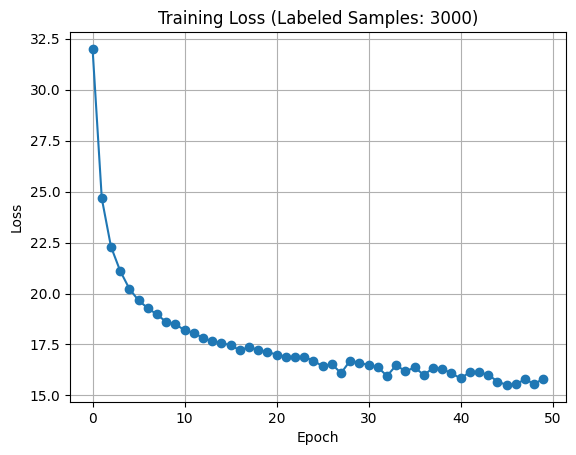

Test Accuracy (3000 labels): 89.67%


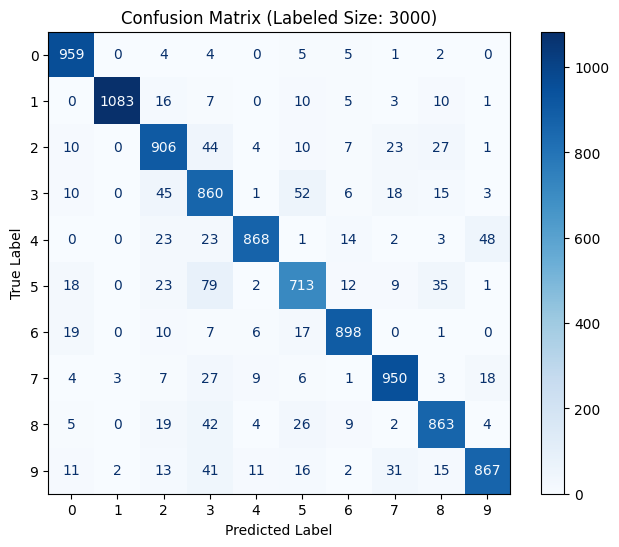

----------------------------------------------------------------
Starting training with 5000 labels and 55000 without labels...
Epoch [1/50], Average Loss: 18.9456
Epoch [2/50], Average Loss: 14.7325
Epoch [3/50], Average Loss: 13.5657
Epoch [4/50], Average Loss: 12.8228
Epoch [5/50], Average Loss: 12.5995
Epoch [6/50], Average Loss: 12.0380
Epoch [7/50], Average Loss: 12.1277
Epoch [8/50], Average Loss: 11.6783
Epoch [9/50], Average Loss: 11.4866
Epoch [10/50], Average Loss: 11.0964
Epoch [11/50], Average Loss: 10.9654
Epoch [12/50], Average Loss: 10.9020
Epoch [13/50], Average Loss: 10.9544
Epoch [14/50], Average Loss: 10.7765
Epoch [15/50], Average Loss: 10.5479
Epoch [16/50], Average Loss: 10.6252
Epoch [17/50], Average Loss: 10.7200
Epoch [18/50], Average Loss: 10.3180
Epoch [19/50], Average Loss: 10.3937
Epoch [20/50], Average Loss: 10.2764
Epoch [21/50], Average Loss: 10.3318
Epoch [22/50], Average Loss: 10.0361
Epoch [23/50], Average Loss: 10.2318
Epoch [24/50], Average Loss: 9

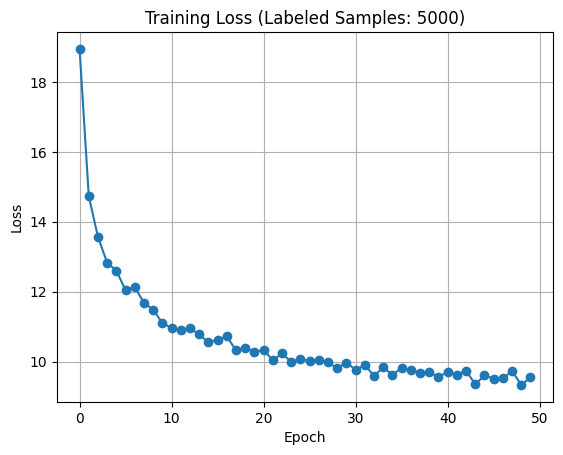

Test Accuracy (5000 labels): 89.99%


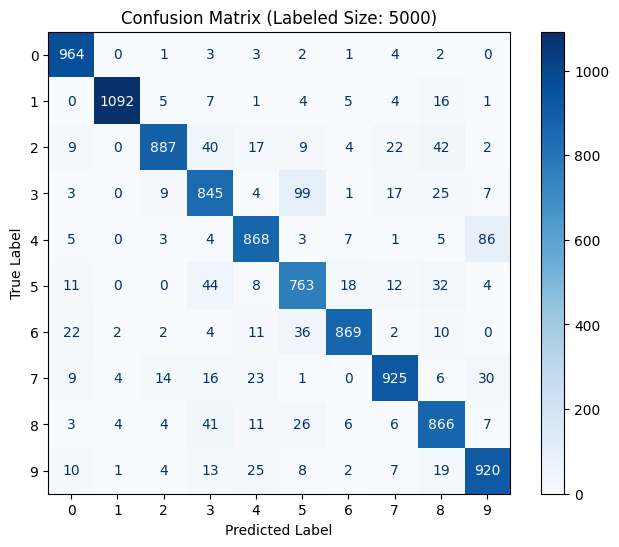

----------------------------------------------------------------


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters.
input_dim = 28 * 28  # MNIST images
hidden_dim = 256
latent_dim = 20
num_classes = 10
learning_rate = 1e-3
batch_size = 256
num_epochs = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

labels_list = [100, 500, 1000, 3000, 5000] # Different label size

    # Create a semi-supervised split:

for labeled_size in labels_list:
    # Split the dataset into labeled and unlabeled subsets randomly

    unlabeled_size = len(train_dataset) - labeled_size # find the unlabeled dataset size
    batch_size_labeled =  max(1, (labeled_size // unlabeled_size))

    indices = torch.randperm(len(train_dataset))

    labeled_indices = indices[:labeled_size]
    unlabeled_indices = indices[labeled_size:]

    labeled_dataset = Subset(train_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    model = SSL(input_dim, hidden_dim, latent_dim, num_classes, learning_rate)
    model = model.to(device)
    epoch_losses = []

    # Training loop
    print(f"Starting training with {labeled_size} labels and {unlabeled_size} without labels...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        labeled_samples_count = 0
        unlabeled_samples_count = 0

        for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
            # # Update counters
            # num_batches += 1
            # labeled_samples_count += x_l.size(0)
            # unlabeled_samples_count += x_u.size(0)

            x_l = x_l.to(device)
            y_l = y_l.to(device)
            x_u = x_u.to(device)

            loss = model.train_step(x_l, y_l, x_u)
            total_loss += loss

        avg_loss = total_loss / (len(labeled_loader)+len(unlabeled_loader))
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")
        #print(f"  Processed {num_batches} batches: {labeled_samples_count} labeled samples, {unlabeled_samples_count} unlabeled samples")

    # Plot training loss curve
    plt.figure()
    plt.plot(epoch_losses, marker='o')
    plt.title(f'Training Loss (Labeled Samples: {labeled_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Evaluate on test data.
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            preds = model.predict(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
    print(f"Test Accuracy ({labeled_size} labels): {accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')

    ax.set_title(f'Confusion Matrix (Labeled Size: {labeled_size})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

    print('----------------------------------------------------------------')




Generating latent space visualization...


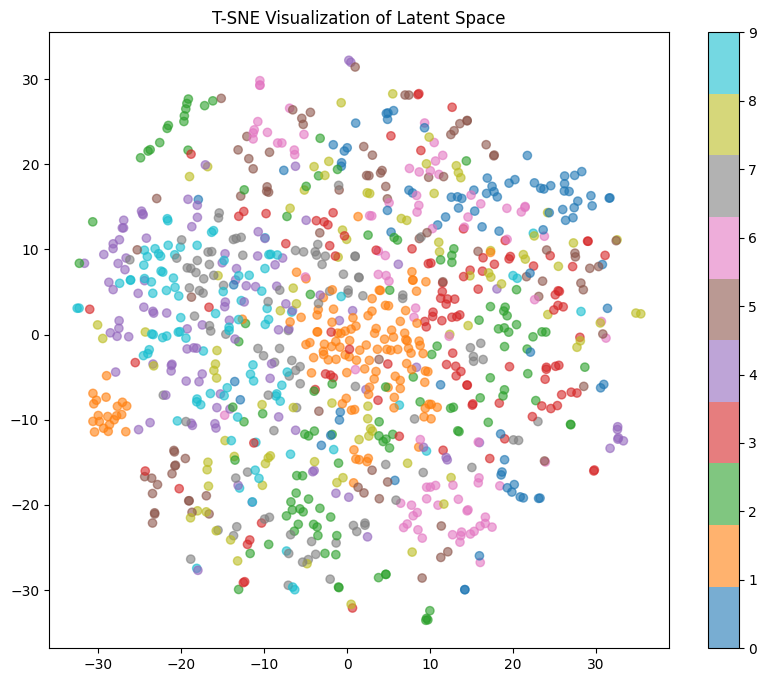

In [9]:
print("Generating latent space visualization...")
model.visualize_latent_tsne(test_loader)

Generating conditional samples...


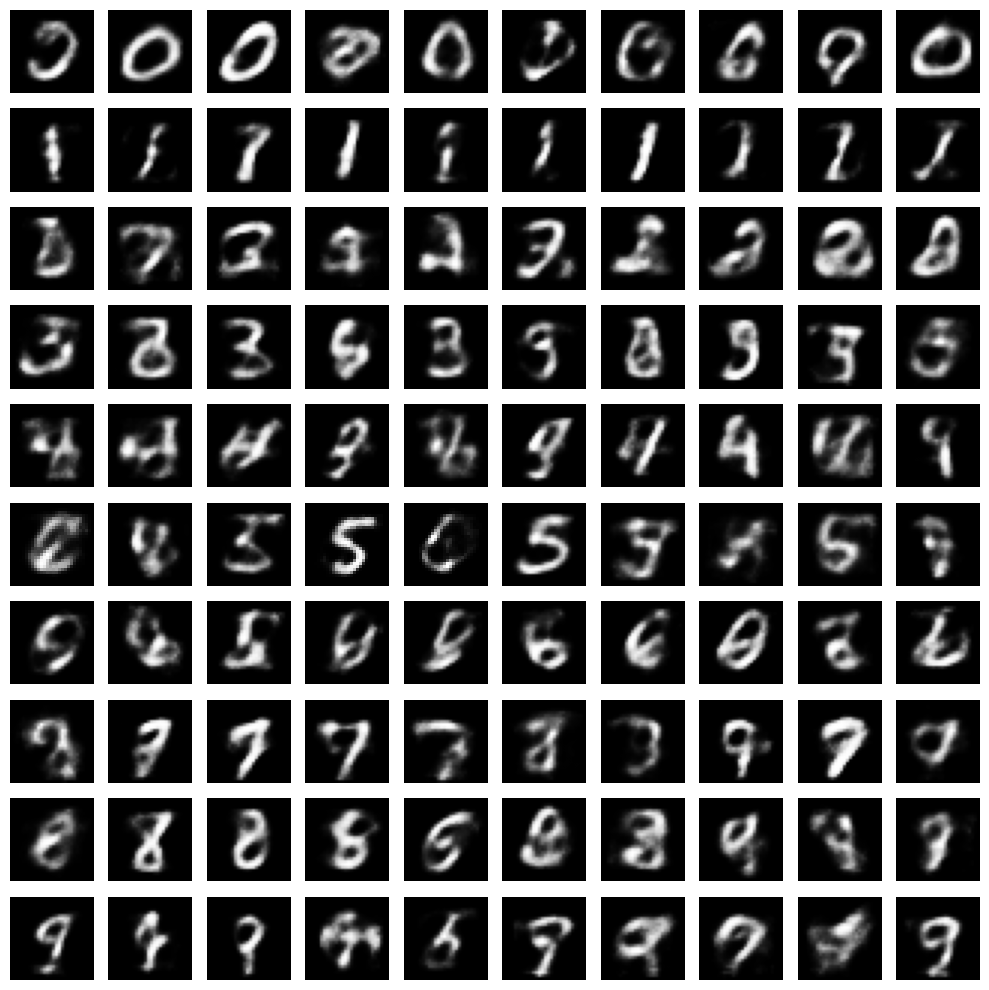

In [10]:
print("Generating conditional samples...")
model.generate_conditional_samples()